In [2]:
import log_reg
import numpy as np
from glob import glob
from matplotlib.pyplot import imread, imshow
from util import read_X_Y, get_data_col, filter_data_by_colval
from keras.models import Sequential 
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
file_names = sorted(glob('all-mias/*.pgm'))

In [4]:
headers = ['file_name', 'character', 'class', 'severity', 'x', 'y', 'radius']
filtered_X, Y = read_X_Y('dataset/data.txt',headers)

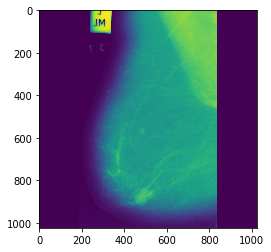

In [19]:
image_stack = np.array([imread(file_name) for file_name in filtered_X])
imshow(image_stack[2])

In [6]:
Y = np.array(Y)
Y = np.squeeze(Y)
print(image_stack.shape)
print(Y.shape)
m,l,h = image_stack.shape
X = image_stack.reshape((m,l*h,1))
X = image_stack.reshape((m,l*h))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.6,random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test,Y_test,train_size=0.5,random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(119, 1024, 1024)
(119, 3)
(71, 1048576)
(71, 3)
(24, 1048576)
(24, 3)
(24, 1048576)
(24, 3)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
print(m*l)

121856


In [24]:
model = Sequential([
    Dense(128, input_shape=(l*h,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(16),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model.compile(optimizer='Adam',
              loss='logcosh')
model.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=32)

Train on 71 samples, validate on 24 samples
Epoch 1/20
71/71 [==============================] - 36s 513ms/step - loss: 24095.5276 - val_loss: 6011.3813
Epoch 2/20
71/71 [==============================] - 11s 156ms/step - loss: 5663.4358 - val_loss: 3766.1484
Epoch 3/20
71/71 [==============================] - 8s 113ms/step - loss: 2417.6948 - val_loss: 342.4896
Epoch 4/20
71/71 [==============================] - 7s 102ms/step - loss: 374.6732 - val_loss: 344.5707
Epoch 5/20
71/71 [==============================] - 8s 112ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 6/20
71/71 [==============================] - 7s 100ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 7/20
71/71 [==============================] - 13s 189ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 8/20
71/71 [==============================] - 9s 128ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 9/20
71/71 [==============================] - 13s 188ms/step - loss: 350.8421 - val_loss: 344.5707
Epoch 10/2

In [26]:
y_pred_val = model.predict(X_val)

In [27]:
print(y_pred_val)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [28]:
print(Y_val)

[[448. 480.  95.]
 [492. 473. 131.]
 [600. 514.  67.]
 [518. 191.  39.]
 [356. 945.  72.]
 [647. 503.  87.]
 [523. 482.  29.]
 [547. 520.  45.]
 [366. 620.  33.]
 [525. 425.  33.]
 [489. 480.  82.]
 [415. 460.  38.]
 [326. 607. 174.]
 [352. 624. 114.]
 [462. 406.  44.]
 [603. 538.  44.]
 [522. 553.  17.]
 [519. 362.  54.]
 [592. 670.  33.]
 [493. 125.  49.]
 [612. 297.  34.]
 [191. 549.  23.]
 [400. 484.  37.]
 [653. 477.  49.]]


In [ ]:
model2 = Sequential([
    Dense(1024, input_shape=(l*h,)),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(256),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model2.compile(optimizer='Adam',
              loss='mean_squared_error')
model2.fit(X_train,Y_train,epochs=20, validation_data=(X_val, Y_val), batch_size=32)

Train on 71 samples, validate on 24 samples
Epoch 1/20


In [18]:
model2 = Sequential([
    Dense(128, input_shape=(l*h,)),
    Activation('relu'),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(16),
    Activation('relu'),
    Dense(3),
    Activation('relu'),
])
model2.compile(optimizer='Adam',
              loss='mean_squared_error')
# print(X_train[0].shape)
model2.fit(,epochs=5, batch_size=32)

(1048576,)


ValueError: Error when checking target: expected activation_55 to have shape (3,) but got array with shape (1,)